# Preparations

In this notebook we will present examples on how to use library BBMetric for evaluate our chatbots.

In [4]:
### Run environment setup
import os
import lib.BBSetup as BBSetup

try:
    from google.colab import drive
    BBSetup.colab_setup(mount_folder=r"/content/drive/My Drive/unibo/NLP_project/BarneyBot")
except:
    BBSetup.anaconda_setup(base_folder=r"E:\University\Esami da Superare\Natural Language Processing\BarneyBotGit\BarneyBotGit",
                           env_name="nlp")

### Define folders
base_folder = BBSetup.BASE_FOLDER
out_folder = BBSetup.set_folder(os.path.join(base_folder, 'Metrics', 'New'))

pip install -r "E:\University\Esami da Superare\Natural Language Processing\BarneyBotGit\BarneyBotGit\requirements.txt"


In [5]:
# Import the metrics library
from lib.BBMetrics import BBMetric 

# Create some basic sentences to feed to the metrics
sentences_basic = ["Hi!", "How are you?", "I hate you."]
sentences_basic_2 = ["Hello!", "How are you doing?", "I think this is good."]
sentences_vader = ["Come to the dark side!", "I will kill you!", "Luke, I am your father."]
sentences_barney = ["Did you get the suit?", "Legendary!", "I like girls."]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tonel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# Pretty print module
import pprint
from lib.BBMetricResults import *

printer = pprint.PrettyPrinter(depth=4, width=300)

# Metrics Info

`BBMetric.metrics_list` show up the list of all the available metrics

In [8]:
# Display the available metrics list
BBMetric.metrics_list

['google bleu',
 'mpnet embedding similarity',
 'rouge l',
 'meteor',
 'emotion classifier',
 'roberta crossencoding similarity',
 'distinct',
 'neural chatbot classifier',
 'perplexity',
 'repetitiveness',
 'term error rate',
 'bertscore',
 'comet',
 'bleurt',
 'word mover distance',
 'bartscore',
 'extended edit distance']

Printing a metric shows its info

In [9]:
# Display info for a loaded metric
metric = BBMetric.load_metric("google bleu")
print(metric)

{'name': 'google bleu', 'args': {'train': {'required': set(), 'optional': set()}, 'compute': {'required': {'predictions', 'references'}, 'optional': set()}}, 'returns': ['score', 'std'], 'description': None, 'paper': None, 'save_actors': ['predictor', 'reference']}


# Running Metrics

`BBMetric.load_metric(metric_name)` load the specified metric with name `metric_name` by loading the respective model or algorithm which computes it. It will return the `metric` asked ready to be compute by invoking `metric.compute`. Some metrics (such as the human ones and the semantic classifier) require training, in which case a method `metric.train` is provided.

In [ ]:
# Google BLEU (Variation of BLEU more useful for sentences) on a pair of sets of sentences
metric = BBMetric.load_metric("google bleu")

print(metric.compute(predictions=sentences_basic, references=sentences_basic_2))

In [7]:
# Symmetric Semantic Similarity on a pair of sets of sentences
metric = BBMetric.load_metric("mpnet embedding similarity")

print(metric.compute(sentences_a=sentences_basic, sentences_b=sentences_basic_2))

{'score': 0.5964817404747009, 'std': 0.4743334650993347}


In [8]:
# Rouge-L on a pair of sets of sentences
metric = BBMetric.load_metric("rouge l")

print(metric.compute(predictions=sentences_basic, references=sentences_basic_2))

{'score': 0.36904761904761907, 'std': 0.3599099156626422}


In [9]:
# METEOR on a pair of sets of sentences
metric = BBMetric.load_metric("meteor")

print(metric.compute(predictions=sentences_basic, references=sentences_basic))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tonel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tonel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\tonel\AppData\Roaming\nltk_data...


{'score': 0.9739583333333334, 'std': 0.025779934730759544}


[nltk_data]   Package omw-1.4 is already up-to-date!


In [10]:
# Emotion labeling on a set of sentences
metric = BBMetric.load_metric("emotion classifier")

'''
for char in ['Barney', 'Bender']:
    char_hg = load_char_df(char, base_folder)
    result = metric.compute(sentences=char_hg['test']['response'])
    print(char + "Emotions")
    printer.pprint({result['label'][i]: result['score'][i] for i in range(len(result['score']))})
'''

print(metric.compute(sentences=sentences_basic))

E:\Programs\Anaconda\envs\nlp\Lib\site-packages\transformers\pipelines\text_classification.py:89: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


{'score': [0.040451311971992254, 0.3372651059180498, 0.0295343438629061, 0.33119263251622516, 0.24915530377378067, 0.012401272969630858], 'std': [0.02466328219141657, 0.3520862192023358, 0.03524458751490872, 0.3607271122098797, 0.31209391813628645, 0.008284036892139822], 'label': ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']}


In [11]:
# Semantic Answer Similarity on a pair of sets of sentences
metric = BBMetric.load_metric("roberta crossencoding similarity")

print(metric.compute(predictions=sentences_basic, references=sentences_basic_2))

{'score': 0.6090299487113953, 'std': 0.4026722013950348}


In [12]:
# Distinct on a set of sentences
metric = BBMetric.load_metric("distinct")

# ngram_size is optional, defaults to 3
metric.compute(sentences=sentences_basic, ngram_size=2)

{'score': 0.1272727272727273, 'std': 0.09030099651970509}

Creating encoded lines


100%|██████████████████████████████████████████████████████████████████████████████| 2750/2750 [03:06<00:00, 14.71it/s]


Saved encoded lines at E:\University\Esami da Superare\Natural Language Processing\BarneyBotGit\BarneyBotGit\data\Characters\Vader
Loaded encoded lines from E:\University\Esami da Superare\Natural Language Processing\BarneyBotGit\BarneyBotGit\data\Characters\Vader
Running shuffle 0/10


100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 5052.84it/s]


Running shuffle 1/10


100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 5055.61it/s]


Running shuffle 2/10


100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 7137.32it/s]


Running shuffle 3/10


100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 5046.84it/s]


Running shuffle 4/10


100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 5055.69it/s]


Running shuffle 5/10


100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 5057.47it/s]


Running shuffle 6/10


100%|█████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 10103.67it/s]


Running shuffle 7/10


100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 5052.45it/s]


Running shuffle 8/10


100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 5054.23it/s]


Running shuffle 9/10


100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 7148.94it/s]


Loading training data...


100%|██████████████████████████████████████████████████████████████████████████| 2686/2686 [00:00<00:00, 333537.63it/s]


Loading test data...


100%|████████████████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<?, ?it/s]


Loading validation data...


100%|████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<?, ?it/s]


Epoch 1/1000
168/168 [==============================] - 10s 39ms/step - loss: 0.8998 - binary_accuracy: 0.5413 - recall: 0.5295 - val_loss: 0.7405 - val_binary_accuracy: 0.5127 - val_recall: 0.0256
Epoch 2/1000
168/168 [==============================] - 6s 34ms/step - loss: 0.8491 - binary_accuracy: 0.5588 - recall: 0.5511 - val_loss: 0.7493 - val_binary_accuracy: 0.5443 - val_recall: 0.2051
Epoch 3/1000
168/168 [==============================] - 6s 34ms/step - loss: 0.8089 - binary_accuracy: 0.5823 - recall: 0.5824 - val_loss: 0.7022 - val_binary_accuracy: 0.6139 - val_recall: 0.4487
Epoch 4/1000
168/168 [==============================] - 6s 35ms/step - loss: 0.7636 - binary_accuracy: 0.5972 - recall: 0.5884 - val_loss: 0.7001 - val_binary_accuracy: 0.6329 - val_recall: 0.5897
Epoch 5/1000
168/168 [==============================] - 6s 34ms/step - loss: 0.7159 - binary_accuracy: 0.6344 - recall: 0.6376 - val_loss: 0.6855 - val_binary_accuracy: 0.6329 - val_recall: 0.6667
Epoch 6/1000
1

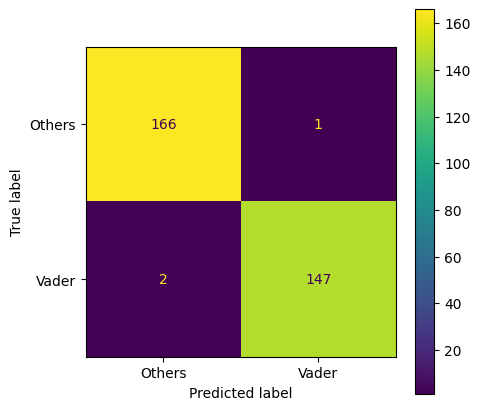

INFO:tensorflow:Assets written to: E:\University\Esami da Superare\Natural Language Processing\BarneyBotGit\BarneyBotGit\data\Characters\Vader\vader_classifier\assets


INFO:tensorflow:Assets written to: E:\University\Esami da Superare\Natural Language Processing\BarneyBotGit\BarneyBotGit\data\Characters\Vader\vader_classifier\assets


{'score': 0.18061189353466034, 'std': 0.18533413112163544}
{'score': 0.28027254343032837, 'std': 0.12468782812356949}
{'score': 0.17582131922245026, 'std': 0.2519037127494812}


In [23]:
# Semantic Classifier on a set of sentences
metric = BBMetric.load_metric("neural chatbot classifier")

# n_shuffles is optional, defaults to 10
# Either specify a source_encoded_path to load encoded lines, or specify a source_path and a source_save_path to create them
# shutdown_at_end is optional, defaults to False
metric.train(character='Vader', random_state=random_state,
             source_encoded_path=None,
             source_path=os.path.join(base_folder, "data", "Sources", character_dict["Vader"]['source'], character_dict["Vader"]['source'] + ".csv"),
             source_save_path=os.path.join(base_folder, "data", "Characters", 'Vader'),
             save_path=os.path.join(base_folder, "data", "Characters", 'Vader'),
             n_shuffles=10, shutdown_at_end=False)

# Computations for Barney semantic classifier on different sets of sentences
print(metric.compute(character='Vader',
                     load_path=os.path.join(base_folder, "Data", "Characters", 'Vader', character_dict["Vader"]['classifier_folder']),
                     sentences=sentences_basic))
print(metric.compute(character='Vader',
                     load_path=os.path.join(base_folder, "Data", "Characters", 'Vader', character_dict["Vader"]['classifier_folder']),
                     sentences=sentences_vader))
print(metric.compute(character='Vader',
                     load_path=os.path.join(base_folder, "Data", "Characters", 'Vader', character_dict["Vader"]['classifier_folder']),
                     sentences=sentences_barney))

In [22]:
# Perplexity on an encoded test set (taken from one of our datasets)
metric = BBMetric.load_metric("perplexity")

# Functions to load a dataset and prepare it, used for perplexity
from transformers import TFAutoModelForCausalLM, AutoTokenizer
from transformers import AdamWeightDecay
from lib.BBData import character_dict, source_dict, random_state, model_name
from datasets import load_dataset, DatasetDict
from transformers import DataCollatorForLanguageModeling
from lib.BBDataLoad import load_char_df, dialogpt_preprocess_function

# Load and compile dialogpt defaul model
model = TFAutoModelForCausalLM.from_pretrained(model_name, cache_dir=os.path.join(base_folder, "cache"))
model.compile(optimizer=AdamWeightDecay(learning_rate=2e-5))
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=os.path.join(base_folder, "cache"))
tokenizer.pad_token = '#'

# Select a batch size, used for perplexity
batch_size = 8

# Load the Vader dialogpt finetuned model
model_vader = TFAutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=\
                    os.path.join(base_folder, 'Data', 'Characters', 'Vader', character_dict['Vader']['checkpoint_folder']))
model_vader.compile()
data_collator = DataCollatorForLanguageModeling(mlm=False, tokenizer=tokenizer, return_tensors='tf')

# Load the Barney dataset and process it as a conversation
vader_hg = load_char_df('Vader', base_folder)
tokenized_vader_hg = vader_hg.map(lambda row: dialogpt_preprocess_function(row, tokenizer), batched=False)
# Transform the HuggingFace dataset as a tensorflow one, ready to be fed to the model
vader_test_set = tokenized_vader_hg["test"].to_tf_dataset(
    columns=["input_ids", "attention_mask", "labels"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

print(metric.compute(model=model_vader, encoded_test_set=vader_test_set))

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at microsoft/DialoGPT-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.
All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at E:\University\Esami da Superare\Natural Language Processing\BarneyBotGit\BarneyBotGit\Data\Characters\Vader\vader_model.
If your task is similar to the task the model of the checkpoint wa

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

E:\Programs\Anaconda\envs\nlp\Lib\site-packages\datasets\download\streaming_download_manager.py:714: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  return pd.read_csv(xopen(filepath_or_buffer, "rb", use_auth_token=use_auth_token), **kwargs)


Dataset csv downloaded and prepared to E:/University/Esami da Superare/Natural Language Processing/BarneyBotGit/BarneyBotGit/Src/cache/csv/default-2716428a75380423/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?ex/s]

  0%|          | 0/16 [00:00<?, ?ex/s]

  0%|          | 0/8 [00:00<?, ?ex/s]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:27<00:00, 13.51s/it]

{'score': 20.613982847195594}


In [13]:
# Repetitiveness of sentences
metric = BBMetric.load_metric("repetitiveness")

print(metric.compute(sentences=sentences_basic))

{'score': 0.2333333333333333, 'std': 0.09428090415820632}


E:\Programs\Anaconda\envs\nlp\Lib\site-packages\nlgmetricverse\metrics\_core\base.py:86: FutureWarning: Metric is deprecated and will be removed in the next major version of datasets. Use the new library 🤗 Evaluate instead: https://huggingface.co/docs/evaluate
  super().__init__(


In [14]:
# TER on a pair of sets of sentences
metric = BBMetric.load_metric("term error rate")

print(metric.compute(predictions=sentences_basic, references=sentences_basic_2))

{'score': 76.66666666666667, 'std': 20.548046676563256}


In [15]:
# BERTScore on a pair of sets of sentences
metric = BBMetric.load_metric("bertscore")

print(metric.compute(predictions=sentences_basic, references=sentences_basic_2))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{'score': 0.8650024731953939, 'std': 0.09010275421675674}


In [16]:
# COMET on a triple of sets of sentences
metric = BBMetric.load_metric("comet")

print(metric.compute(sources=sentences_basic, predictions=sentences_barney, references=sentences_basic_2))

E:\Programs\Anaconda\envs\nlp\Lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


{'score': -1.1263877749443054, 'std': 0.19313412800715013}


In [17]:
# BLEURT on a pair of sets of sentences
metric = BBMetric.load_metric("bleurt")

print(metric.compute(predictions=sentences_barney, references=sentences_basic))

INFO:tensorflow:Reading checkpoint C:\Users\tonel\.cache\huggingface\metrics\bleurt\default\downloads\extracted\b094b72f3dc7e1712a641ab624024c3b182ff714848ee334f1cc7a628d0b7798\bleurt-base-128.


INFO:tensorflow:Reading checkpoint C:\Users\tonel\.cache\huggingface\metrics\bleurt\default\downloads\extracted\b094b72f3dc7e1712a641ab624024c3b182ff714848ee334f1cc7a628d0b7798\bleurt-base-128.


INFO:tensorflow:Config file found, reading.


INFO:tensorflow:Config file found, reading.


INFO:tensorflow:Will load checkpoint bert_custom


INFO:tensorflow:Will load checkpoint bert_custom


INFO:tensorflow:Loads full paths and checks that files exists.


INFO:tensorflow:Loads full paths and checks that files exists.


INFO:tensorflow:... name:bert_custom


INFO:tensorflow:... name:bert_custom


INFO:tensorflow:... vocab_file:vocab.txt


INFO:tensorflow:... vocab_file:vocab.txt


INFO:tensorflow:... bert_config_file:bert_config.json


INFO:tensorflow:... bert_config_file:bert_config.json


INFO:tensorflow:... do_lower_case:True


INFO:tensorflow:... do_lower_case:True


INFO:tensorflow:... max_seq_length:128


INFO:tensorflow:... max_seq_length:128


INFO:tensorflow:Creating BLEURT scorer.


INFO:tensorflow:Creating BLEURT scorer.


INFO:tensorflow:Creating WordPiece tokenizer.


INFO:tensorflow:Creating WordPiece tokenizer.


INFO:tensorflow:WordPiece tokenizer instantiated.


INFO:tensorflow:WordPiece tokenizer instantiated.


INFO:tensorflow:Creating Eager Mode predictor.


INFO:tensorflow:Creating Eager Mode predictor.


INFO:tensorflow:Loading model.


INFO:tensorflow:Loading model.


INFO:tensorflow:BLEURT initialized.


INFO:tensorflow:BLEURT initialized.


{'score': -1.504532257715861, 'std': 0.18247956505028967}


In [18]:
# Word Mover Distance on a pair of sets of sentences
metric = BBMetric.load_metric("word mover distance")

print(metric.compute(predictions=sentences_vader, references=sentences_vader))

{'score': 0.0, 'std': 0.0}


In [19]:
# BARTScore on a pair of sets of sentences
metric = BBMetric.load_metric("bartscore")

print(metric.compute(predictions=sentences_barney, references=sentences_basic))

{'score': -4.447240034739177}


In [20]:
# EED on a pair of sets of sentences
metric = BBMetric.load_metric("extended edit distance")

print(metric.compute(predictions=sentences_barney, references=sentences_basic))

{'score': 0.8360909024874369, 'std': 0.05260148578323149}


# Saving & Loading Metrics

In [ ]:
# Metric metadata creation
metric_name = 'dummy metric'
metric_name_pretty = 'Dummy Metric'
metric_version = 1
metric_actors = {
    "document": [
        MetricActor.DATASET_CHAR,
        "Barney"
    ],
    "training_set": [
        MetricActor.DATASET_CHAR,
        "Barney"
    ]
}
metric_result = {
    "score": 0.9984034299850464,
    "std": 0.027748608961701393
}
metric_attempt = 0
metric_context = {                          
    "dialogpt_size": "small",
    "dialogpt_context_sentences": 5,
    "dialogpt_nbeams_beams": 3,
    "dialogpt_sample_top_p": 0.92,
    "dialogpt_sample_top_k": 50
}
metric_params = {}
metric_samples = 'Unknown'
metric_hash = dict_hash({'metric_name': metric_name,
                                         'metric_version': metric_version,
                                         'metric_attempt': metric_attempt,
                                         'metric_actors': metric_actors,
                                         'context': metric_context,
                                         'metric_params': metric_params,
                                         'metric_samples': metric_samples})

# This is the important one. Each metric should contain all these entries
metric_dict = {
        "metric_name": metric_name,           # Unique name of the metric
        "metric_version": metric_version,     # Metric version (useful if you change how a metric works and recompute)
        "metric_attempt": metric_attempt,     # Incremental value for multiple computations of the same metric (e.g. for std)
        "metric_actors": metric_actors,       # Who this metric is computed on
        "metric_dependency": get_metric_dependency(metric_name, metric_actors), # Is this metric a function of data or chatbot?
        "metric_params": metric_params,       # Additional params of the metric (e.g. ngram_size for distinct)
        "context": metric_context,            # External parameters, such as chatbot characteristics
        "metric_arity": get_metric_arity(metric_name), # Metric arity
        "metric_samples": metric_samples,     # Batch size of the metric
        "metric_determinism": get_metric_determinism(metric_name, metric_version), # Is this metric algorithmic or not?
        "answer": metric_result,              # Score of the metric, may include std (Any dictionary can go here)
        "hash": metric_hash                   # Unique hash for this metric, used to not store duplicates
    }

metric_dict = {
    metric_hash: metric_dict
}
printer.pprint(metric_dict) # Metric is now ready to be saved!

In [ ]:
# Save metrics
save_metric_by_name(out_folder, 'Dummy Metric', metric_dict)

In [ ]:
# Load metrics
metric_dict = load_metric_by_name(out_folder, 'Dummy Metric')
printer.pprint(metric_dict)